<a href="https://colab.research.google.com/github/snotani/neural-networks-ECG/blob/main/MLP_ECG_DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Load dataset and pre-processing

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# ECG dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

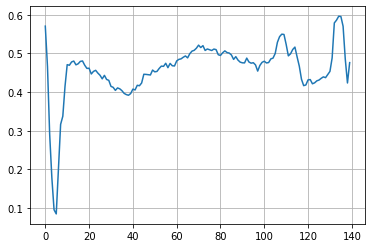

In [34]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)
train_len = len(train_data)
test_len = len(test_data)

# Normalize to [0, 1]
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

# plot data
plt.grid()
plt.plot(np.arange(140), train_data[0])
plt.show()

In [35]:
train_data = np.array(train_data)
X = train_data
y = train_labels

examples = y.shape[0]
y = y.reshape(1,examples) 

digits = 2  # for 2 classes of ECG normal and abnormal
Y = np.eye(digits)[y.astype('int32')] 
Y = Y.T.reshape(digits, examples).T

X2 = test_data
y2 = test_labels

examples = y2.shape[0]
y2 = y2.reshape(1, examples)
Y2 = np.eye(digits)[y2.astype('int32')]
Y2 = Y2.T.reshape(digits, examples).T

# Basic functions

In [36]:
def sigmoid(x):
  """
  Computes the sigmoid function sigm(input) = 1/(1+exp(-input))
  """
  return 1 / (1 + np.exp(-x))

def sigmoid_(y):
  """
  Computes the derivative of sigmoid funtion. sigmoid(y) * (1.0 - sigmoid(y)). 
  The way we implemented this requires that the input y is already sigmoided
  """
  return y * (1-y)

def dense(inputs, weights, bias):
    """A simple dense layer."""
    return np.matmul(inputs, weights)+bias

def initialize_weights(input_sz, hidden_sz, output_sz):
    # weights for hidden layer, shape: 2x3
    w1 = np.random.uniform(size=(input_sz, hidden_sz))
    b1 = np.random.uniform(size=(1, hidden_sz))
    # weights for output layer, shape: 3x1
    w2 = np.random.uniform(size=(hidden_sz, output_sz))
    b2 = np.random.uniform(size=(1, output_sz))
    return w1, w2, b1, b2 

def forward_pass(X, w1, w2, b1, b2):
    # Step 1: Calculate weighted average of inputs (output shape: 4x3)
    net_hidden = dense(X, w1, b1)
    
    # Step 2: Calculate the result of the sigmoid activation function (shape: 4x3)
    act_hidden = sigmoid(net_hidden)
    
    # Step 3: Calculate output of neural network (output shape: 4x1)
    y_hat = dense(act_hidden, w2, b2)
    
    return act_hidden, y_hat

def mse(y_hat, y):
    residual = y_hat - y
    error = np.mean(0.5 * (residual ** 2))
    return residual, error    

def backward_pass(X, y_hat, y, w1, w2, b1, b2, act_hidden):
    # Step 1: Calculate error
    residual, error = mse(y_hat, y)
    
    # Step 2: calculate gradient wrt w2
    N = X.shape[0]
    dL_dy = 1.0 / N * residual  # shape (4, 1)
    dy_dw2 = act_hidden  # shape (4, 3)
    dL_dw2 = np.matmul(dL_dy.T, dy_dw2)  # shape (1, 3)
    dL_db2 = np.matmul(dL_dy.T, dy_dw2*0+1)  # shape (1, 3)
    
    # According to the math, `dL_dw2` is a row-vector, however, `w2` is a column-vector.
    # To prevent erroneous numpy broadcasting during the gradient update, we must make
    # sure that `dL_dw2` is also a column-vector.
    dL_dw2 = dL_dw2.T
    dL_db2 = np.sum(dL_db2.T, 0)
    
    # Step 3: calculate gradient wrt w1
    dL_dw1 = 1.0 / N * np.matmul(X.T, np.matmul(residual, w2.T) * sigmoid_(act_hidden))
    dL_db1 = 1.0 / N * np.matmul(X.T*0+1, np.matmul(residual, w2.T) * sigmoid_(act_hidden))
    dL_db1=np.sum(dL_db1,0);

    return dL_dw2, dL_dw1, dL_db2, dL_db1, error

# Training

In baches, with bias and a learning rate

Epoch 0> Training error: 1.588895
Epoch 0> Training error: 1.649029
Epoch 200> Training error: 1.064273
Epoch 200> Training error: 1.063137
Epoch 400> Training error: 0.701525
Epoch 400> Training error: 0.786315
Epoch 600> Training error: 0.550244
Epoch 600> Training error: 0.513507
Epoch 800> Training error: 0.369956
Epoch 800> Training error: 0.400417
Epoch 1000> Training error: 0.279897
Epoch 1000> Training error: 0.253452
Epoch 1200> Training error: 0.155639
Epoch 1200> Training error: 0.132857
Epoch 1400> Training error: 0.128571
Epoch 1400> Training error: 0.188644
Epoch 1600> Training error: 0.166771
Epoch 1600> Training error: 0.148774
Epoch 1800> Training error: 0.136687
Epoch 1800> Training error: 0.136663
Epoch 2000> Training error: 0.175315
Epoch 2000> Training error: 0.129215
Epoch 2200> Training error: 0.139106
Epoch 2200> Training error: 0.124674
Epoch 2400> Training error: 0.135761
Epoch 2400> Training error: 0.108033
Epoch 2600> Training error: 0.147467
Epoch 2600> Tra

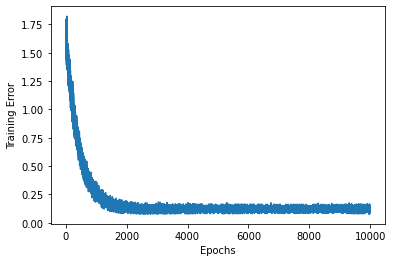

In [39]:
n_epochs = 10000
learning_rate = 0.0001
training_errors = []

batchsize = 8
nbatches = 2

input_size = X.shape[1] 
hidden_size = 3
output_size = 2

# re-initialize the weights to be sure we start fresh
w1, w2, b1, b2 = initialize_weights(input_size, hidden_size, output_size)

for epoch in range(n_epochs):
  # shuffle the data sample sequences
  permutation = np.random.permutation(X.shape[0])
  X_shuffled = X[permutation,:]
  Y_shuffled = Y[permutation,:]

  for j in range(nbatches):
    #take minibatch samples from shuffled train dataset
    # get mini-batch
    begin = j * batchsize
    end = min(begin + batchsize, X.shape[0])
    X_batch = X_shuffled[begin:end, :]
    Y_batch = Y_shuffled[begin:end, :]
    m_batch = end - begin

    # Step 1: forward pass
    act_hidden, y_hat = forward_pass(X_batch, w1, w2, b1, b2)
    
    # Step 2: backward pass
    dw2, dw1, db2, db1, error = backward_pass(X_batch, y_hat, Y_batch, w1, w2, b1, b2, act_hidden)
    
    # Step 3: apply gradients scaled by learning rate
    w2 = w2 - learning_rate * dw2
    w1 = w1 - learning_rate * dw1
    b2 = b2 - learning_rate * db2
    b1 = b1 - learning_rate * db1

    # Step 4: some book-keeping and print-out
    if epoch % 200 == 0:
        print('Epoch %d> Training error: %f' % (epoch, error))
    training_errors.append([epoch, error])

# Plot training error progression over time
training_errors = np.asarray(training_errors)
plt.plot(training_errors[:, 0], training_errors[:, 1]);
plt.xlabel('Epochs');
plt.ylabel('Training Error');

# Test

In [41]:
# Train error
act_hidden, Y_hat = forward_pass(X, w1, w2, b1, b2)
residual, error = mse(Y_hat, Y)
acc=1-np.sum((np.argmax(Y_hat, axis=1)==np.argmax(Y, axis=1))*1,0)/Y.shape[0]
print('Train>> Mean square error: %f     Accuracy: %f' % (np.sqrt(error), acc*100))

# Test error
act_hidden2, Y_hat2 = forward_pass(X2, w1, w2, b1, b2)
residual, error = mse(Y_hat2, Y2)
acc=1-np.sum((np.argmax(Y_hat2, axis=1)==np.argmax(Y2, axis=1))*1,0)/Y2.shape[0]
print('Test>> Mean square error: %f     Accuracy: %f' % (np.sqrt(error), acc*100))

Train>> Mean square error: 0.347831     Accuracy: 40.995498
Test>> Mean square error: 0.352081     Accuracy: 44.000000
